In [1]:
using Pkg
using Plots
using BenchmarkTools
using CircularArrays
#using Contour

Pkg.DEFAULT_IO[] = stdout
Pkg.activate("../.")
include("../Staggered/Grid/Staggered.jl")
include("../Staggered/Grid/Periodic_avg.jl")
include("../Staggered/Advection/Periodic_2D.jl")

  Activating environment at `~/Desktop/PhD/Codes/julia_package/ToyModel.jl/Project.toml`


adv_y_Euler! (generic function with 1 method)

In [2]:
g = 9.81

Lx, Ly = 6, 6
nx, ny = 101, 101
grid = Grid(nx, ny, -Lx/2, Lx/2, -Ly/2, Ly/2);

In [3]:
Xt = zeros(nx, ny)
Yt = zeros(nx, ny)

for i in 1:grid.nx
    for j in 1:grid.ny
        Xt[i, j] = grid.xt[i]
        Yt[i, j] = grid.yt[j]
    end
end

In [4]:
U_old = zeros(nx, ny)
U_new = zeros(nx, ny)
V_old = zeros(nx, ny)
V_new = zeros(nx, ny)

U_avg = zeros(nx, ny)
V_avg = zeros(nx, ny)

h_old = zeros(nx, ny)
h_mean = 1
expo = 10
@. h_old = h_mean + 0.01*exp(-expo*(Xt^2 + Yt^2))
h_new = zeros(nx, ny)

# Initialising variables to be used repeatedly in iterations
Uavg_x = zeros(nx, ny)
havg_x = zeros(nx, ny)
Vavg_y = zeros(nx, ny)
havg_y = zeros(nx, ny)
Uavg_xy = zeros(nx, ny)
Vavg_xy = zeros(nx, ny)
Uadv_x = zeros(nx, ny)
Uadv_y = zeros(nx, ny)
dUdx = zeros(nx, ny)
dUdy = zeros(nx, ny)
Vadv_x = zeros(nx, ny)
Vadv_y = zeros(nx, ny)
dVdx = zeros(nx, ny)
dVdy = zeros(nx, ny)
dhdx = zeros(nx, ny)
dhdy = zeros(nx, ny)
dhdx_no = zeros(nx, ny)
dhdy_no = zeros(nx, ny)
xflow_sign = zeros(nx, ny)
yflow_sign = zeros(nx, ny);

In [5]:
f = 0

t_start = 0
t_end = 1.5
dt = 0.001

for i in t_start:dt:t_end
    
    @. xflow_sign = sign(U_old)
    @. yflow_sign = sign(V_old)
    avg_val(U_old, V_old, h_old, Uavg_x, havg_x, Vavg_y, havg_y, Uavg_xy, Vavg_xy, grid)
    
    ∂xu_cd!(Uadv_x, Array(U_old.*U_old./havg_x), grid, false)
    ∂yu_cd!(Uadv_y, Array(U_old.*Vavg_xy./havg_x), grid, false)
    ∂xu_cd!(Vadv_x, Array(Uavg_xy.*V_old./havg_y), grid, false)
    ∂yu_cd!(Vadv_y, Array(V_old.*V_old./havg_y), grid, false)
    
    ∂xt_cd!(dhdx, h_old, grid, true)
    ∂yt_cd!(dhdy, h_old, grid, true)
    ∂xt_cd!(dhdx_no, h_old, grid, false)
    ∂yt_cd!(dhdy_no, h_old, grid, false)
    ∂xu_cd!(dUdx, U_old, grid, true)
    ∂yu_cd!(dVdy, V_old, grid, true)
    
    @. U_new = U_old - dt*(Uadv_x + Uadv_y - f*Vavg_xy + g*dhdx*havg_x)
    @. V_new = V_old - dt*(Vadv_x + Vadv_y + f*Uavg_xy + g*dhdy*havg_y)
    @. h_new = h_old - dt*(dUdx + dVdy)
    
    U_old = U_new
    V_old = V_new
    h_old = h_new
    
end

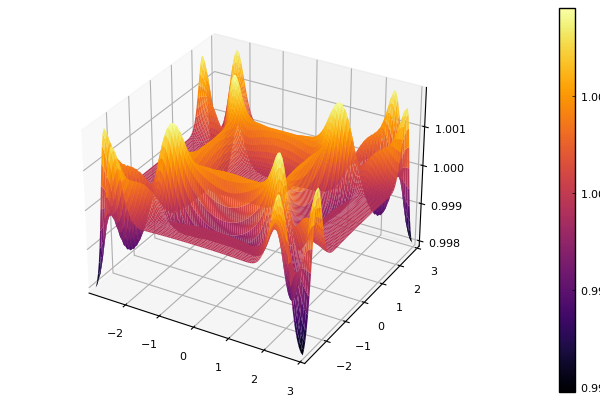

In [6]:
pyplot()
plot(Xt, Yt, h_new, st=:surface)

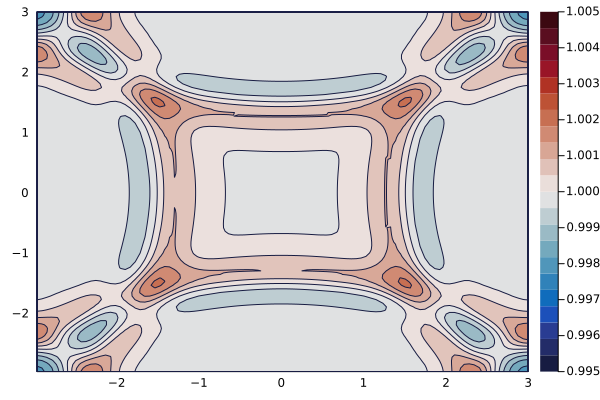

In [10]:
gr()
contourf(grid.xt, grid.yt, h_new, c = :balance, levels = 21, clim = (0.995, 1.005))